# Sources of water

We consider pore water and chemically bound water within major volatile-carrying reservoirs. Table 3 in Faccenda (2014) is a useful resource summarising each component. We produce grids of the in-plate water content in Mt/m$^2$ for each reservoir.

#### Key references

1. Faccenda, M. Water in the slab: A trilogy. Tectonophysics 614, 1–30 (2014). doi:[10.1016/j.tecto.2013.12.020](http://dx.doi.org/10.1016/j.tecto.2013.12.020)
2. Jarrard, R. D. Subduction fluxes of water, carbon dioxide, chlorine, and potassium. Geochemistry, Geophys. Geosystems 4, (2003). doi:[10.1029/2002GC000392](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002GC000392)
3. Van Keken, P. E., Hacker, B. R., Syracuse, E. M. & Abers, G. A. Subduction factory: 4. Depth-dependent flux of H2O from subducting slabs worldwide. J. Geophys. Res. Solid Earth 116, (2011). doi:[10.1029/2010JB007922](http://dx.doi.org/10.1029/2010JB007922)
4. Hacker, B. R. H2O subduction beyond arcs. Geochemistry, Geophys. Geosystems 9, (2008). doi:[10.1029/2007GC001707](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007GC001707)

#### Contents

1. [water in the lithosphere](#water-in-the-lithosphere)
2. [water in sediments](#water-in-sediments)
3. [water in the crust](#water-in-the-crust)

__Create zarr storage__

First, we must make sure the directories exist for us to put the grids corresponding to each water reservoir

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import gplately
from gplately import PlateModelManager
from gplately.grids import read_netcdf_grid, write_netcdf_grid
from pathlib import Path
import os
from joblib import Parallel, delayed

In [8]:
pmm = PlateModelManager()
pm = pmm.get_model("Muller2022")

model = gplately.PlateReconstruction(pm.get_rotation_model(), pm.get_topologies(), pm.get_static_polygons())
gplot = gplately.PlotTopologies(model, pm.get_coastlines(), pm.get_continental_polygons(), pm.get_COBs())

In [31]:
# define timesteps
min_time, max_time = 0, 540
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

# define grid size
spacingX = 0.1
spacingY = 0.1
nx = int(360.0/spacingX) + 1
ny = int(180.0/spacingY) + 1
nt = reconstruction_times.size

save_output_netcdf = True

In [13]:
# Lithosphere
lithosphere_top_dir = "Reservoirs/Lithosphere/top/"
lithosphere_bottom_dir = "Reservoirs/Lithosphere/bottom/"

# Crust
crust_bound_dir = "Reservoirs/Crust/bound/"
crust_pore_dir  = "Reservoirs/Crust/pore/"

# Sediments
sediments_bound_dir = "Reservoirs/Sediment/bound/"
sediments_pore_dir = "Reservoirs/Sediment/pore/"

quantities = ['min', 'mean', 'max']

# create directories if they do not already exist
for path in [lithosphere_top_dir,
             lithosphere_bottom_dir,
             crust_bound_dir,
             crust_pore_dir,
             sediments_bound_dir,
             sediments_pore_dir]:
    
    for m in ["min", "mean", "max"]:
        full_path = path + m + "/"
        if not os.path.exists(full_path):
            os.makedirs(full_path)

In [15]:
# common data files
plate_model_dir = "/Users/ben/git/carbonate-platform-degassing/Data/Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.1/"
agegrid_filename = plate_model_dir + "SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
spreadrate_filename = plate_model_dir + "SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.2f}Ma.nc"

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

In [16]:
def surface_area_oblate_spheroid(r1, r2):
    e = np.sqrt(1.0 - r2**2/r1**2)
    return 2.0*np.pi*r1**2*(1.0 + (1.0-e**2)/e * np.arctanh(e))

def lat_area_function(latitude_one, latitude_two, longitude_resolution):
    '''
    Calculates the point area of an evenly gridded lat/lon mesh
    Longitude resolution is lon2 - lon1
    '''
    dlat = np.sin(np.radians(latitude_two)) - np.sin(np.radians(latitude_one))
    lat_area = 2 * np.pi * 6371.009e3**2 * np.abs(dlat)/longitude_resolution
    return lat_area

lon_grid = np.arange(-180, 180+spacingX, spacingX)
lat_grid = np.arange(-90, 90+spacingY, spacingX)

cell_area = lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## water in the lithosphere

H$_2$O influx and outflux is related to the following parameters:

- $u$ Spreading rate
- $d$ Compaction length (fixed?)
- $T$ Temperature of the mantle
- $c$ Fertility of the mantle
- $v$ H2O volatile content (elevated near hotspots)

These are fitted from a series of polynomial functions to get units of t/m/yr.

__Ridge outflux fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}})
$$

__Plate influx fit:__

This is actually metasomatism connected to the base of the lithosphere and is separate from serpentinisation due to mantle unroofing which occurs at the surface.

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}}) + C_v (v^2 - v_{\mathrm{ref}}^2)
$$

We want to convert t/m/yr to t/m2

> __Citation:__
> Keller, T., Katz, R. F., & Hirschmann, M. M. (2017). Volatiles beneath mid-ocean ridges: Deep melting, channelised transport, focusing, and metasomatism. Earth and Planetary Science Letters, 464, 55–68. https://doi.org/10.1016/j.epsl.2017.02.006

In [17]:
u_ref = 3.0
d_ref = 1.504
T_ref = 1350.0
c_ref = 19.0
v_ref = 100.0

def ridge_outflux(u, d, T, c, v):
    u = np.abs(u)
    A = 0.9919
    B_u = 0.3162
    B_d = -0.3739
    B_T = 0.0089
    B_c = 0.0294
    B_v = 0.0095
    return A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref)

def plate_influx(u, d, T, c, v):
    u = np.abs(u)
    A = 0.8807
    B_u = 0.262
    B_d = 0.3589
    B_T = -0.00029097
    B_c = 0.0075
    B_v = 0.0054
    C_v = 0.000035532
    F = A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref) + \
         C_v*(v**2 - v_ref**2)
    return F

print(ridge_outflux(u_ref, d_ref, T_ref, c_ref, 150.0))
print(plate_influx(u_ref, d_ref, T_ref, c_ref, 150.0))

1.4668999999999999
1.59485


In [18]:
subduction_data = model.tessellate_subduction_zones(0, tessellation_threshold_radians, ignore_warnings=True)
subduction_lon = subduction_data[:,0]
subduction_lat = subduction_data[:,1]
subduction_length  = np.radians(subduction_data[:,6]) * gplately.EARTH_RADIUS * 1e3 # in metres
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

ridge_data = model.tessellate_mid_ocean_ridges(0, tessellation_threshold_radians, ignore_warnings=True)
ridge_lon = ridge_data[:,0]
ridge_lat = ridge_data[:,1]
ridge_vel = ridge_data[:,2]
ridge_length = np.radians(ridge_data[:,3]) * 1e3 * gplately.EARTH_RADIUS

volatile_output = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_ref)

print("Average volatile extraction rate = {:.2f} t/m/yr".format(volatile_output.mean()))
print("Global volatile output = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output * ridge_length).sum()*1e-6,
    (volatile_output * ridge_length).sum()*1e3/1e12))

Average volatile extraction rate = 0.81 t/m/yr
Global volatile output = 52.28 Mt/yr = 0.05 x10^12 kg/yr


__Plate influx at top of mantle lithosphere__

The __Iyer et al. 2010__ model of mantle hydration related to half-spreading rate. We fit their curves using the function,

$$
f(x) = \frac{a}{x+b}
$$

> Iyer, K., Rüpke, L. H. & Morgan, J. P. Feedbacks between mantle hydration and hydrothermal convection at ocean spreading centers. Earth Planet. Sci. Lett. 296, 34–44 (2010). doi:[10.1016/j.epsl.2010.04.037](http://dx.doi.org/10.1016/j.epsl.2010.04.037)

In [19]:
hsr = np.array([0, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7])
h2o_lo_perm = np.array([3, 2.5, 1.8, 1.4, 1, 0.75, 0.5, 0.5, 0.5, 0.5]) * 1e5
h2o_hi_perm = np.array([3, 2.5, 1.7, 1.1, 0.6, 0.45, 0.5, 0.4, 0.3, 0.25]) *1e5

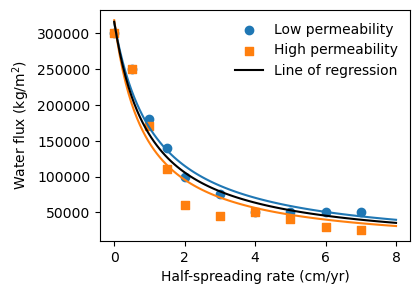

In [20]:
from scipy.optimize import curve_fit

def curve(x, a, b):
    return a/(x+b) 

popt1, pcov1 = curve_fit(curve, hsr, h2o_lo_perm)
popt2, pcov2 = curve_fit(curve, hsr, h2o_hi_perm)
popt3 = 0.5*(popt1 + popt2) # average curve

hsr_array = np.linspace(0., 8, 100)


fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111, ylabel='Water flux (kg/m$^2$)', xlabel='Half-spreading rate (cm/yr)')
ax1.scatter(hsr, h2o_lo_perm, label='Low permeability')
ax1.scatter(hsr, h2o_hi_perm, label='High permeability', marker='s')
# plt.plot(hsr, poly(hsr))
ax1.plot(hsr_array, curve(hsr_array, *popt1))
ax1.plot(hsr_array, curve(hsr_array, *popt2))
ax1.plot(hsr_array, curve(hsr_array, *popt3), c='k', label='Line of regression')
ax1.legend(frameon=False)
fig.savefig("H2O_spreading_rate_regression.pdf", bbox_inches='tight')
fig.savefig("H2O_spreading_rate_regression.png", bbox_inches='tight', dpi=300)

In [21]:
spreadrate_grid = gplately.Raster(spreadrate_filename.format(0), resample=(spacingX,spacingY))

# Iyer (top of lithospheric mantle)
volatile_grid = gplately.Raster(data=curve(0.5*spreadrate_grid/10, *popt3), extent=extent_globe)
volatile_grid.fill_NaNs(inplace=True)
volatile_output = volatile_grid.interpolate(subduction_lon, subduction_lat)


print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length*subduction_convergence).sum()*1e-9,
    (volatile_output*subduction_length*subduction_convergence).sum()/1e12))

Average volatile uptake = 85548.89 kg/m2
Global volatile uptake = 206.33 Mt/yr = 0.21 x10^12 kg/yr


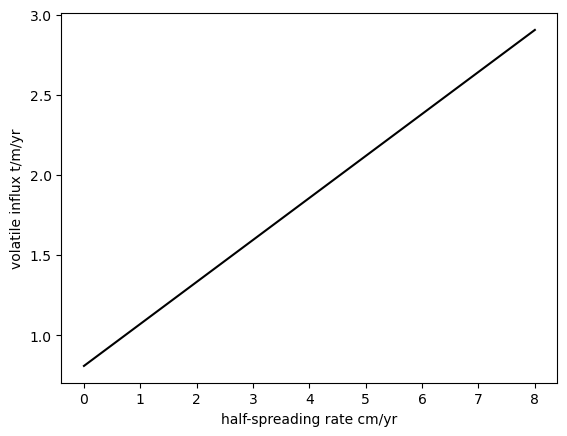

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel='half-spreading rate cm/yr', ylabel='volatile influx t/m/yr')
plt.plot(hsr_array, plate_influx(hsr_array, d_ref, T_ref, c_ref, 150.0), 'k-')

In [23]:
spreadrate_grid = gplately.grids.read_netcdf_grid(spreadrate_filename.format(0), resample=(spacingX,spacingY))

# Keller (base of lithospheric mantle)
volatile_grid = gplately.Raster(data=plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_ref),
                                extent=extent_globe)
volatile_grid.fill_NaNs(inplace=True)
volatile_output = volatile_grid.interpolate(subduction_lon, subduction_lat)


print("Average volatile extraction rate = {:.2f} t/m/yr".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length).sum()*1e-6,
    (volatile_output*subduction_length).sum()*1e3/1e12))

Average volatile extraction rate = 1.05 t/m/yr
Global volatile uptake = 65.55 Mt/yr = 0.07 x10^12 kg/yr


In [ ]:
water_lithosphere_top_filename = lithosphere_top_dir + "{}/water_lithosphere_grid_{}.nc"
water_lithosphere_bottom_filename = lithosphere_bottom_dir + "{}/water_lithosphere_grid_{}.nc"

def reconstruct_water_lithosphere(reconstruction_time):
    ## Keller
    # mm/yr
    spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(reconstruction_time), resample=(spacingX,spacingY))
    
    # t/m/yr
    H2O_influx_grid_min  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, 90.0)
    H2O_influx_grid_mean = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, 100.0)
    H2O_influx_grid_max  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, 110.0)
    
    water_lithosphere_bottom = np.ma.array([H2O_influx_grid_min, H2O_influx_grid_mean, H2O_influx_grid_max])
    
    # unit conversions
    water_lithosphere_bottom /= spreadrate_grid*1e-3 # mm/yr to m/yr
    water_lithosphere_bottom *= 1e-6 # convert t/m^2 to Mt/m^2
    
    ## Iyer
    H2O_influx_top_mean =  curve(0.5*spreadrate_grid/10, *popt3) * 1e-9 # convert kg/m^2 to Mt/m^2
    H2O_influx_top_min  =  curve(0.5*spreadrate_grid/10, *popt2) * 1e-9 # convert kg/m^2 to Mt/m^2
    H2O_influx_top_max  =  curve(0.5*spreadrate_grid/10, *popt1) * 1e-9 # convert kg/m^2 to Mt/m^2
    
    water_lithosphere_top = np.ma.array([H2O_influx_top_min, H2O_influx_top_mean, H2O_influx_top_max])
    
    # Mt C
    total_water_lithosphere_bottom = np.nansum(water_lithosphere_bottom*cell_area, axis=(1,2))
    total_water_lithosphere_top    = np.nansum(water_lithosphere_top*cell_area, axis=(1,2))
    
    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_lithosphere_bottom_filename.format(m, reconstruction_time),
                              water_lithosphere_bottom[i])
            write_netcdf_grid(water_lithosphere_top_filename.format(m, reconstruction_time),
                              water_lithosphere_top[i])

    return np.array(np.hstack([total_water_lithosphere_bottom, total_water_lithosphere_top]))

In [33]:
total_water_lithosphere = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_water_lithosphere)(time) for time in reconstruction_times)

total_water_lithosphere = np.array(total_water_lithosphere)
total_water_lithosphere_bottom = total_water_lithosphere[:,:3]
total_water_lithosphere_top    = total_water_lithosphere[:,3:]

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-3)]: Done 541 out of 541 | elapsed:  8.1min finished


## water in sediments

Two sources of water in sediments: pore and bound water

1. __Pore water:__ use the sedimentary thickness grids convert to water depth based a porosity-depth relationship
2. __Bound water:__ water bound in the sediment matrix itself

In [34]:
def convert_sediment_to_water(sediment_thickness, sediment_surface_porosity=0.66, decay_constant=1333):
    """Convert sediment thickness into water thickness based on porosity assuming a single
    “average ocean floor sediment” lithology.

    
    Assuming the porosity decays exponentially, the volume of water within sediment of thickness 'T' is:
    
       Integral(porosity(z), z = 0 -> 0 + T) = Integral(porosity(0) * exp(-z / decay), z = 0 -> 0 + T)
                                             = -decay * porosity(0) * (exp(-T/decay) - 1)
                                             = decay * porosity(0) * (1 - exp(-T/decay))


    Returns a list of tuples (longitude, latitude, water_thickness)
    """
    water_thickness = decay_constant*sediment_surface_porosity * (
        1.0 - np.exp(-sediment_thickness/decay_constant))

    return water_thickness

In [35]:
sediments_filename = plate_model_dir + "TotalSedimentThickness/sed_thick_0.1d_{:.1f}.nc"

seds_grid = gplately.Raster(filename=sediments_filename.format(0), resample=(spacingX,spacingY))
seds_grid.fill_NaNs(inplace=True)
sediment_thickness = seds_grid.interpolate(subduction_lon, subduction_lat)

water_thickness = convert_sediment_to_water(sediment_thickness)
volatile_output = water_thickness*1020 # m to kg/m2 multiply by the density of fluid

print("-- PORE WATER --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-9,
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-12))


matrix_thickness = sediment_thickness - water_thickness
volatile_output = 0.07*sediment_thickness*1700 # convert m to kg/m2 (multiply by mean sediment density), 7 wt%

print("-- BOUND WATER --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-9,
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-12))

-- PORE WATER --
Average volatile uptake = 154352.16 kg/m2
Global volatile uptake = 388.00 Mt/yr = 0.39 x10^12 kg/yr
-- BOUND WATER --
Average volatile uptake = 37397.64 kg/m2
Global volatile uptake = 93.58 Mt/yr = 0.09 x10^12 kg/yr


In [39]:
water_sediments_bound_filename = sediments_bound_dir+"{}/water_sediment_grid_{}.nc"
water_sediments_pore_filename  = sediments_pore_dir +"{}/water_sediment_grid_{}.nc"

def reconstruct_water_sediment(reconstruction_time):
    # compacted sediment thickness (metres)
    seds_grid = read_netcdf_grid(sediments_filename.format(reconstruction_time), resample=(spacingX, spacingY))

    ## Bound H2O
    # average 7 wt% water with average density of 1700 kg/m3
    water_sediments_bound = np.ma.array([0.06*seds_grid, 0.07*seds_grid, 0.08*seds_grid])*1700
    water_sediments_bound *= 1e-9 # convert kg/m2 to Mt/m2
    
    ## Pore H2O
    water_thickness_mean = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.66)
    water_thickness_min  = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.5)
    water_thickness_max  = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.75)
    water_sediments_pore = np.ma.array([water_thickness_min, water_thickness_mean, water_thickness_max]) * 1020
    water_sediments_pore *= 1e-9 # convert kg/m2 to Mt/m2
    
    
    total_water_sediments_bound = np.nansum(water_sediments_bound*cell_area, axis=(1,2))
    total_water_sediments_pore  = np.nansum(water_sediments_pore*cell_area, axis=(1,2))

    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_sediments_bound_filename.format(m, reconstruction_time),
                              water_sediments_bound[i])
            
            write_netcdf_grid(water_sediments_pore_filename.format(m, reconstruction_time),
                              water_sediments_pore[i])
    
    return np.array(np.hstack([total_water_sediments_bound, total_water_sediments_pore]))

In [41]:
total_water_sediment = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_water_sediment)(time) for time in reconstruction_times)

total_water_sediment = np.array(total_water_sediment)
total_water_sediment_bound = total_water_sediment[:,:3]
total_water_sediment_pore  = total_water_sediment[:,3:]

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-3)]: Done 541 out of 541 | elapsed:  6.6min finished


## water in the crust

> Jarrard, R. D. Subduction fluxes of water, carbon dioxide, chlorine, and potassium. Geochemistry, Geophys. Geosystems 4, (2003). doi:[10.1029/2002GC000392](doi.org/10.1029/2002GC000392)

In [42]:
def macro_porosity(age):
    return 13.01 - 5.625*np.log10(age)

def structural_H2O(rho, phi):
    return (103.1 - 34.27*rho) + 0.17*(1.031 - phi)

def bulk_density(phi, rho):
    return (0.01*phi)*1.02 + (1.0 - 0.01*phi)*rho

def total_crust_H2O_wt_structural(age):
    ones = np.ones_like(age)
    phi_u = macro_porosity(age)
    phi_l = phi_u/2
    rho_u = 3.01 - 0.0631*np.log10(age)
    rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    rho_d = 2.98
    rho_g = 2.99
    H2O_wt_u = structural_H2O(rho_u, phi_u)
    H2O_wt_l = structural_H2O(rho_l, phi_l)
    H2O_wt_d = 1.76
    H2O_wt_g = 0.79
    # (H2O_wt_u*300 + H2O_wt_l*300 + H2O_wt_d*1400 + H2O_wt_g*5000)/(300+300+1400+5000) # weighted av
    return H2O_wt_u*ones, H2O_wt_l*ones, H2O_wt_d*ones, H2O_wt_g*ones

def total_crust_H2O_wt_pore(age):
    ones = np.ones_like(age)
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_u = phi_u*1.02/rho_u
    H2O_wt_l = phi_l*1.02/rho_l
    H2O_wt_d = phi_d*1.02/rho_d
    H2O_wt_g = phi_g*1.02/rho_g
    return H2O_wt_u*ones, H2O_wt_l*ones, H2O_wt_d*ones, H2O_wt_g*ones

def total_crust_H2O_flux_structural(age):
    # H2O_wt_u*rho_u*1e3*300 + H2O_wt_l*rho_l*1e3*300 + H2O_wt_d*rho_d*1e3*1400 + H2O_wt_g*rho_g*1e3*5000
    rho_u = 3.01 - 0.0631*np.log10(age)
    rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    rho_d = 2.98
    rho_g = 2.99
    H2O_wt_us, H2O_wt_ls, H2O_wt_ds, H2O_wt_gs = total_crust_H2O_wt_structural(age)
    H2O_wt_up, H2O_wt_lp, H2O_wt_dp, H2O_wt_gp = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_us*(1.0 - 0.01*H2O_up)*300
    flux_l = H2O_wt_ls*(1.0 - 0.01*H2O_lp)*300
    flux_d = H2O_wt_ds*(1.0 - 0.01*H2O_dp)*1400
    flux_g = H2O_wt_gs*(1.0 - 0.01*H2O_gp)*5000
    return flux_u, flux_l, flux_d, flux_g
    
def total_crust_H2O_flux_structural(age):
    # H2O_wt_u*rho_u*1e3*300 + H2O_wt_l*rho_l*1e3*300 + H2O_wt_d*rho_d*1e3*1400 + H2O_wt_g*rho_g*1e3*5000
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_us, H2O_wt_ls, H2O_wt_ds, H2O_wt_gs = total_crust_H2O_wt_structural(age)
    H2O_wt_up, H2O_wt_lp, H2O_wt_dp, H2O_wt_gp = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_us*(1.0 - 0.01*H2O_wt_up)/100*rho_u*1e3*300
    flux_l = H2O_wt_ls*(1.0 - 0.01*H2O_wt_lp)/100*rho_l*1e3*300
    flux_d = H2O_wt_ds*(1.0 - 0.01*H2O_wt_dp)/100*rho_d*1e3*1400
    flux_g = H2O_wt_gs*(1.0 - 0.01*H2O_wt_gp)/100*rho_g*1e3*5000
    return flux_u + flux_l + flux_d + flux_g

def total_crust_H2O_flux_pore(age):
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_u, H2O_wt_l, H2O_wt_d, H2O_wt_g = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_u/100*rho_u*1e3*300
    flux_l = H2O_wt_l/100*rho_l*1e3*300
    flux_d = H2O_wt_d/100*rho_d*1e3*1400
    flux_g = H2O_wt_g/100*rho_g*1e3*5000
    return flux_u + flux_l + flux_d + flux_g

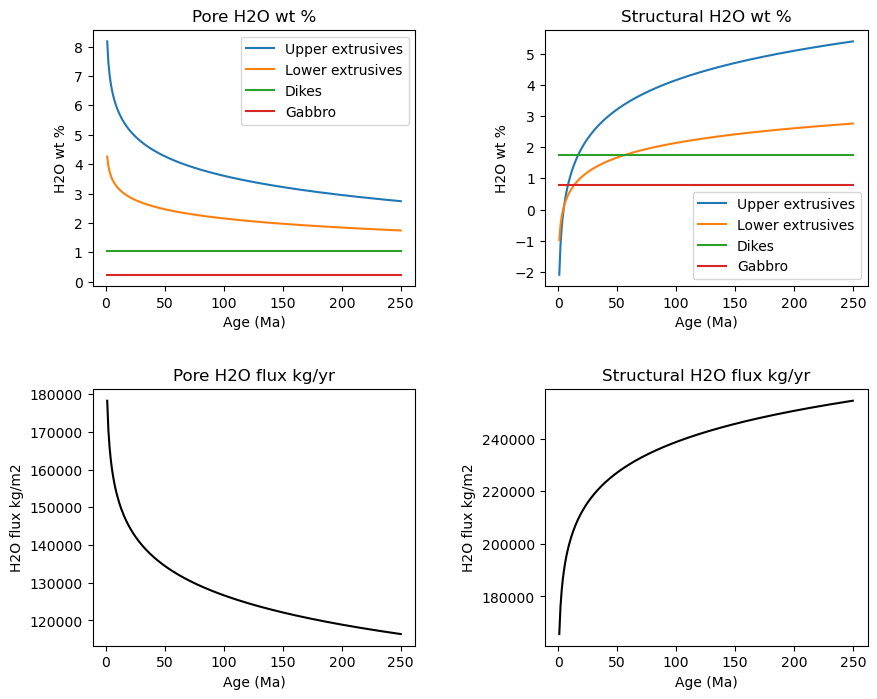

In [43]:
age = np.arange(1,251)


labels = ['Upper extrusives', 'Lower extrusives', 'Dikes', 'Gabbro']

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221,  ylabel='H2O wt %', title='Pore H2O wt %', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_pore(age)):
    ax1.plot(age, wt, label=labels[i])


ax2 = fig.add_subplot(222,  ylabel='H2O wt %', title='Structural H2O wt %', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_structural(age)):
    ax2.plot(age, wt, label=labels[i])
    

ax1.legend()
ax2.legend()


ax3 = fig.add_subplot(223, ylabel='H2O flux kg/m2', xlabel='Age (Ma)', title='Pore H2O flux kg/yr')
ax3.plot(age, total_crust_H2O_flux_pore(age), c='k')

ax4 = fig.add_subplot(224, ylabel='H2O flux kg/m2', xlabel='Age (Ma)', title='Structural H2O flux kg/yr')
ax4.plot(age, total_crust_H2O_flux_structural(age), c='k')


fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax1.plot(age, macro_porosity(age), c='k')

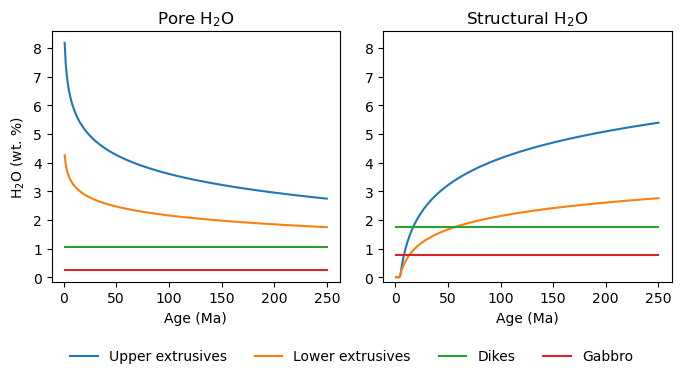

In [44]:
fig = plt.figure(figsize=(8,3.25))

ax1 = fig.add_subplot(121,  ylabel='H$_2$O (wt. %)', title='Pore H$_2$O', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_pore(age)):
    ax1.plot(age, wt, label=labels[i])

handles = []

ax2 = fig.add_subplot(122, title='Structural H$_2$O', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_structural(age)):
    l1, = ax2.plot(age, np.clip(wt, 0, 1e99), label=labels[i])
    handles.append(l1)

ax2.set_ylim(ax1.get_ylim())
fig.subplots_adjust(wspace=0.15)

fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5,-0.06), frameon=False)
# ax2.legend()

fig.savefig('age_H2O_wt_percent.pdf', bbox_inches='tight')
fig.savefig('age_H2O_wt_percent.png', bbox_inches='tight', dpi=300)

In [45]:
age_grid = gplately.Raster(filename=agegrid_filename.format(0), resample=(spacingX,spacingY))
age_grid.data = np.clip(age_grid.data, 0.001, 1e99)
age_grid.fill_NaNs(inplace=True)
age_interp = age_grid.interpolate(subduction_lon, subduction_lat)

volatile_output = total_crust_H2O_flux_structural(age_interp)

print("-- Structural H2O flux --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length*subduction_convergence).sum()*1e-9,
    (volatile_output*subduction_length*subduction_convergence).sum()/1e12))

volatile_output = total_crust_H2O_flux_pore(age_interp)

print("-- Pore H2O flux --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length*subduction_convergence).sum()*1e-9,
    (volatile_output*subduction_length*subduction_convergence).sum()/1e12))

-- Structural H2O flux --
Average volatile uptake = 218496.36 kg/m2
Global volatile uptake = 613.74 Mt/yr = 0.61 x10^12 kg/yr
-- Pore H2O flux --
Average volatile uptake = 141487.17 kg/m2
Global volatile uptake = 381.90 Mt/yr = 0.38 x10^12 kg/yr


In [46]:
water_crust_bound_filename = crust_bound_dir+"{}/water_crust_grid_{}.nc"
water_crust_pore_filename  = crust_pore_dir +"{}/water_crust_grid_{}.nc"

def reconstruct_water_crust(reconstruction_time):
    # compacted sediment thickness (metres)
    age_grid = read_netcdf_grid(agegrid_filename.format(reconstruction_time), resample=(spacingX,spacingY))
    age_grid = np.clip(age_grid, 0.001, 1e99)

    ## Bound H2O
    water_crust_bound_grid = total_crust_H2O_flux_structural(age_grid) * 1e-9
    water_crust_bound = np.ma.array([water_crust_bound_grid*0.9,water_crust_bound_grid,water_crust_bound_grid*1.1])
    
    ## Pore H2O
    water_crust_pore_grid  = total_crust_H2O_flux_pore(age_grid) * 1e-9
    water_crust_pore  = np.ma.array([water_crust_pore_grid*0.9, water_crust_pore_grid, water_crust_pore_grid*1.1])

    
    total_water_crust_bound = np.nansum(water_crust_bound*cell_area, axis=(1,2))
    total_water_crust_pore  = np.nansum(water_crust_pore*cell_area, axis=(1,2))

    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_crust_bound_filename.format(m, reconstruction_time),
                              water_crust_bound[i])
            
            write_netcdf_grid(water_crust_pore_filename.format(m, reconstruction_time),
                              water_crust_pore[i])
    
    return np.array(np.hstack([total_water_crust_bound, total_water_crust_pore]))

In [47]:
total_water_crust = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_water_crust)(time) for time in reconstruction_times)

total_water_crust = np.array(total_water_crust)
total_water_crust_bound = total_water_crust[:,:3]
total_water_crust_pore  = total_water_crust[:,3:]

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/gplately2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-3)]: Done 541 out of 541 | elapsed: 11.3min finished


## Total water

A plot of all contributions to the global water budget

In [48]:
def smooth_1D(array, sigma=3.0, axis=0):
    """ Gaussian filter with standard deviation """
    return ndimage.gaussian_filter1d(array, sigma, axis=axis)

In [52]:
import pandas as pd
from scipy import ndimage

data_out = [total_water_lithosphere_bottom,
            total_water_lithosphere_top,
            total_water_crust_bound,
            total_water_crust_pore,
            total_water_sediment_bound,
            total_water_sediment_pore]

total_water = np.array(data_out).sum(axis=0)
data_out.append(total_water)

headers  = ['lithosphere_bottom', 'lithosphere_top',
            'crust_bound', 'crust_pore',
            'sediment_bound', 'sediment_pore',
            'total']
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])
df = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df.to_csv('01-in-plate-water.csv', index_label='Age (Ma)')


# df = pd.read_csv("figures/01-in-plate-water.csv", header=[0,1], index_col=0)

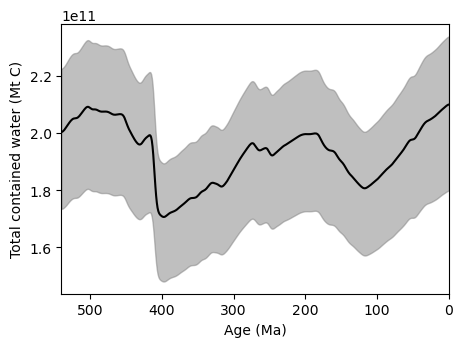

In [57]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained water (Mt C)', xlim=[max_time, min_time])

ax.fill_between(reconstruction_times, smooth_1D(total_water[:,0]), smooth_1D(total_water[:,2]),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, smooth_1D(total_water[:,1]), 'k',   label='Mean')
fig.savefig("figures/total_contained_water.pdf", bbox_inches='tight', dpi=300)

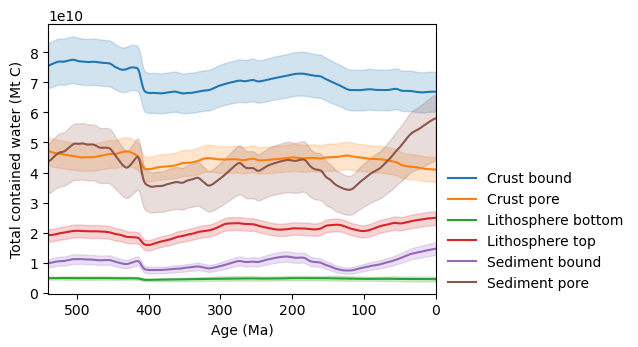

In [58]:
# compare each contribution

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained water (Mt C)', xlim=[max_time, min_time])
# ax.set_yscale('log')

for i, col in enumerate(df.columns.levels[0]):
    if col == 'total':
        continue
    water_contribution = df[col]
    
    ax.fill_between(reconstruction_times,
                    smooth_1D(water_contribution['min']),
                    smooth_1D(water_contribution['max']),
                    color="C{}".format(i), alpha=0.2,)
    
    label = col.replace('_', ' ')
    label = label.capitalize()
    ax.plot(reconstruction_times, smooth_1D(water_contribution['mean']), c='C{}'.format(i), label=label)


ax.legend(bbox_to_anchor=(1,0.5), frameon=False)
fig.savefig("figures/total_contained_water_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)

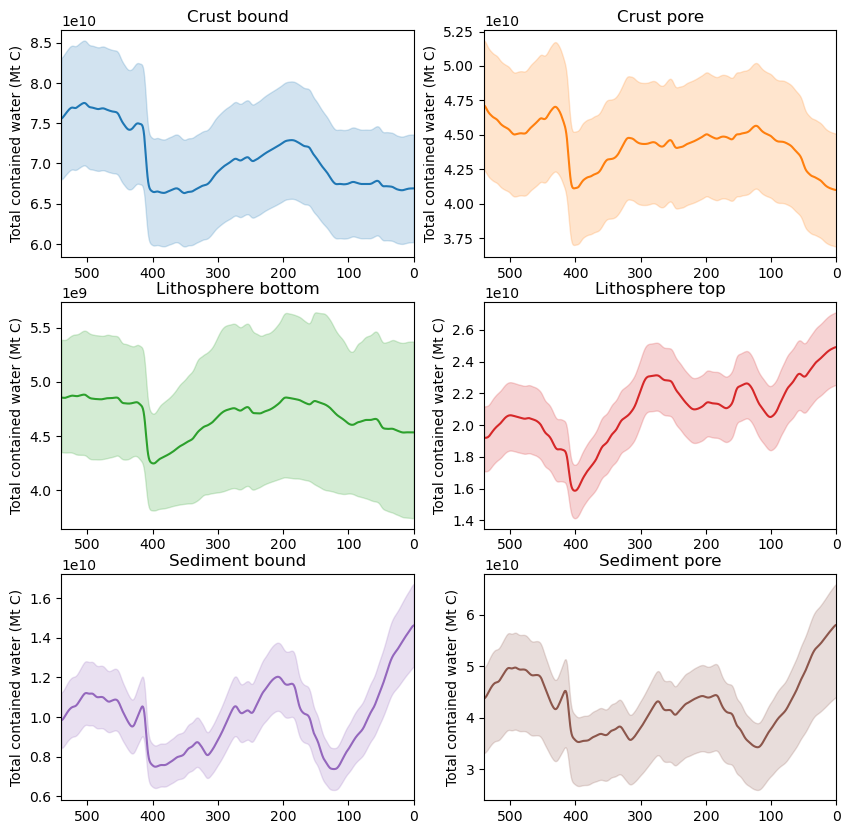

In [59]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,10))

axes = [ax1,ax2,ax3,ax4,ax5,ax6]


for i, col in enumerate(df.columns.levels[0]):
    if col == 'total':
        continue
    
    ax = axes[i]
#     ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Total contained water (Mt C)')
    ax.set_xlim(max_time, min_time)
    label = col.replace('_', ' ')
    label = label.capitalize()
    ax.set_title(label)
    
    water_contribution = df[col]
    
    ax.fill_between(reconstruction_times,
                    smooth_1D(water_contribution['min']),
                    smooth_1D(water_contribution['max']),
                    color="C{}".format(i), alpha=0.2,)

    ax.plot(reconstruction_times, smooth_1D(water_contribution['mean']), c='C{}'.format(i), label=label)


fig.savefig("figures/total_contained_water_comparison.pdf", bbox_inches='tight', dpi=300)